In [21]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
from psycopg2.extras import execute_values
from datetime import datetime
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import copy
import matplotlib.ticker as ticker
from setuptools import setup, find_packages
from math import factorial
from simanneal import Annealer
from itertools import islice 
import matplotlib.patches as patches
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
from itertools import combinations, chain
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Greedy forward partitioning

In [160]:
merged = pd.read_sql('''select * from congestion.merged_segments_v2 where length >200
''',con)

In [161]:
def handle_subsection(subsection, prev_i, max_segment_length=250.):
    # Scans through each subsection of `lengths`, grouping together
    # segments up to `max_segment_length`.
    subsec_segments = [{'idx': [prev_i, ], 'length': subsection[0]}]

    if len(subsection) > 1:
        for i, item in enumerate(subsection[1:]):
            if subsec_segments[-1]['length'] + item < max_segment_length or (i== 0 and subsec_segments[0]['length'] < 100):
                subsec_segments[-1]['idx'].append(i + prev_i + 1)
                subsec_segments[-1]['length'] += item
            elif subsec_segments[-1]['length'] + item > max_segment_length:
                subsec_segments.append({'idx': [i + prev_i + 1, ], 'length': item})
    return subsec_segments

In [ ]:
# forward partition
max_multi_length = 250.
min_segment_length = 100.
for index, row in merged.iterrows():
    segment_id = merged['segment_id'].iloc[index].astype(float)
    lengths = merged['length_set'].iloc[index]
    link_dir = merged['link_set'].iloc[index]    
    segments = []
    segments.extend(handle_subsection(lengths, 0))
    segments = sorted(segments, key=lambda x: x['idx'][0])
    too_small = [i for i in range(len(segments)) if segments[i]['length'] < 100]
    n_deleted = 0

    for ir in too_small:
        i = ir - n_deleted
        if i == 0:
            segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
            segments[1]['length'] += segments[i]['length']
        elif i == len(segments) - 1:
            segments[-2]['idx'] += segments[i]['idx']
            segments[-2]['length'] += segments[i]['length']
        else:
            if segments[i - 1]['length'] >= segments[i + 1]['length']:
                segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
                segments[i + 1]['length'] += segments[i]['length']
            else:
                segments[i - 1]['idx'] += segments[i]['idx']
                segments[i - 1]['length'] += segments[i]['length']
        del segments[i]
        n_deleted += 1
    rows = []
    for i in range(len(segments)):
        id = i
        new_length = segments[i]['length']
        link_set = []
        for i in segments[i]['idx']:
            link_set.append(link_dir[i])
        row = (segment_id, id, link_set, new_length)
        rows.append(row) 
    sql = '''insert into congestion.test_pythonmerge_probs(segment_id, id, link_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)

## Best Group

In [58]:
small_groups = pd.read_sql('''with sets as (
select * from congestion.merged_segments_v2 inner join 
(select distinct segment_id from congestion.partition_result)long using (segment_id))

, int as (select  *, unnest(length_set) as lengths, array_length(length_set, 1) from sets
where array_length(length_set, 1) <=30 and array_length(length_set, 1) >2   order by array_length(length_set, 1))
select segment_id, start_vid, end_vid, link_set,array_agg(lengths::int order by row_number) as length_set, length
from (select row_number() over (), * from int)a	 where segment_id in (1165)
group by segment_id, start_vid, end_vid, link_set, length	

                                ''',con)

Text(0, 0.5, 'Number of segments')

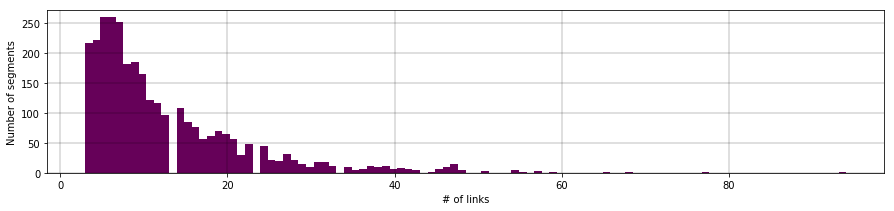

In [4]:

class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''with sets as (
                        select * from congestion.merged_segments_v2 inner join 
                        (select distinct segment_id from congestion.partition_result)long
                        using (segment_id))
                        select array_length(length_set, 1) as length from sets where array_length(length_set, 1) > 2 ''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.length, bins=100, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('# of links')
plt.ylabel('Number of segments')    

In [97]:
def get_num_groups(length_set, length):
    num_link = len(length_set)
    long_link = 0
    for i in length_set:
        if i >200:
            long_link = long_link + 1
    groups = 1+ int(length/200) + long_link
    start = int(length/200)
    if groups > num_link:
        groups = num_link
    else: 
        groups = groups
    if start > groups:
        start = num_link-2
    else:
        start = start
    print(start)
    print(long_link)
    if start <5 or start-1-long_link < 1:
        range = [1, groups]
    else:
        range = [start-1-long_link , groups]
    return num_link, range


def calculate_num_combination(num_link, range1):
    total_com = 0
    for i in range(range1[0], range1[1]):
        x = num_link - 1
        y = i - 1
        com = factorial(x)/(factorial(y)*factorial(x-y))
        total_com = total_com + com
    return total_com    

def split_list(data, n):
    for splits in combinations(range(1, len(data)), n-1):
        result = []
        prev = None
        for split in chain(splits, [None]):
            result.append(data[prev:split])
            prev = split
        yield result
        
def return_results(length_set, groups):
    possibility = []
    for q in range(groups[0], groups[1]):
        split_result = split_list(length_set, q)
        for a in split_result:  
            possibility.append(a)           
    group_result = []
    group_set = []
    for groups in possibility:
        result = []
        sets = []
        for set in groups:
            sum_length = sum(set)
            result.append(sum_length)
            sets.append(set)
        group_result.append(result) 
        group_set.append(sets)
    return group_result, group_set        

def evaluate_results(return_groups):
    print(return_groups)
    set_result = []
    for set in return_groups:
        sum_diff = 0
        for i in range(len(set)):
            diff = abs(200-set[i])
            sum_diff = sum_diff + diff
        set_result.append(sum_diff)  
    selection = set_result.index(min(set_result))
    return selection

def find_link(group_set, selection):
    length_to_split = []
    for i in group_set[selection]:
         length_to_split.append(len(i))

    Input = iter(link_dir) 
    split_link = [list(islice(Input, elem)) 
              for elem in length_to_split] 
    return split_link, group_set[selection]

In [148]:
all_results = pd.read_sql('''select segment_id, link_set ,id,  length_set, length, 'v4' as version
                             from congestion.partition_all_possibility_v4 where segment_id in (3361, 76) 
                             union
                             select segment_id, link_set ,id,  length_set, length, 'v3' as version
                             from congestion.partition_all_possibility_v3 where segment_id in (3361, 76) 
                             order by version, segment_id, id
                             ''',con)

In [ ]:
def evaluate_results(return_groups):
    set_result = []
    for set in return_groups:
        sum_diff = 0
        for i in range(len(set)):
            diff = abs(200-set[i])
            sum_diff = sum_diff + diff
        set_result.append(sum_diff)  
    selection = set_result.index(min(set_result))
    return selection

In [98]:
rows = []

start_time = datetime.now()
for index, row in small_groups.iterrows():
    now = datetime.now()
    row = []
    groups = None
    length_set = small_groups['length_set'].iloc[index]
    link_dir = small_groups['link_set'].iloc[index] 
    segment_id = small_groups['segment_id'].iloc[index].astype(float)
    length = small_groups['length'].iloc[index].astype(float)
    print('Segment ID: ' + str(segment_id))
    # Get number of dividing groups based on length and number of links
    num_link, groups = get_num_groups(length_set, length)
    num_group = calculate_num_combination(num_link, groups)

    if num_group <= 15000000:
        print('Number of combination:' + str(num_group))
        # Return divided group set
        return_groups, group_set = return_results(length_set, groups)
        # Make selection based on summed length
        selection = evaluate_results(return_groups)

        done = datetime.now()
        print(done-now)

        # Retrieve selected partitioned array
        result_link, result_length = find_link(group_set, selection)
        return_groups = []
        group_set = []
        # Prepare rows for sql inserting
        for i in range(len(result_link)):
            new_link_set = result_link[i]
            new_length = sum(result_length[i]) 
            new_length_set = result_length[i]
            row = (segment_id, i, new_link_set, new_length_set, new_length)
            rows.append(row)             

end_time = datetime.now()
print(end_time-start_time)              
       
#sql = '''insert into congestion.partition_all_possibility_v2(segment_id, id, link_set, length_set, length) VALUES %s'''    
#with con:
#    with con.cursor() as cur:
#        execute_values(cur, sql, rows)     

Segment ID: 1165.0
6
5
Number of combination:127.0
[[2417], [210, 2207], [547, 1870], [1133, 1284], [1241, 1176], [1302, 1115], [1580, 837], [1680, 737], [210, 337, 1870], [210, 923, 1284], [210, 1031, 1176], [210, 1092, 1115], [210, 1370, 837], [210, 1470, 737], [547, 586, 1284], [547, 694, 1176], [547, 755, 1115], [547, 1033, 837], [547, 1133, 737], [1133, 108, 1176], [1133, 169, 1115], [1133, 447, 837], [1133, 547, 737], [1241, 61, 1115], [1241, 339, 837], [1241, 439, 737], [1302, 278, 837], [1302, 378, 737], [1580, 100, 737], [210, 337, 586, 1284], [210, 337, 694, 1176], [210, 337, 755, 1115], [210, 337, 1033, 837], [210, 337, 1133, 737], [210, 923, 108, 1176], [210, 923, 169, 1115], [210, 923, 447, 837], [210, 923, 547, 737], [210, 1031, 61, 1115], [210, 1031, 339, 837], [210, 1031, 439, 737], [210, 1092, 278, 837], [210, 1092, 378, 737], [210, 1370, 100, 737], [547, 586, 108, 1176], [547, 586, 169, 1115], [547, 586, 447, 837], [547, 586, 547, 737], [547, 694, 61, 1115], [547, 694

## Simulated annealing

In [2]:
anneal = pd.read_sql('''with sets as (
                        select * from congestion.merged_segments_v2
                        )
                        select * from sets
                        where array_length(length_set, 1) >=5 ''',con)

In [3]:
class LineSegment:
    """Line segment information."""
    
    def __init__(self, id, length):
        self._id = id
        self._length = length
    
    @property
    def id(self):
        return self._id
    
    @property
    def length(self):
        return self._length
    
    def __repr__(self):
        return "{0}: {1}".format(self._id, self._length)

In [5]:
def get_n_part(corridor, d=200.):
    """Get recommended number of partitions for a corridor, following
    the equation above.
    
    Parameters
    ----------
    corridor : list
        List of corridor lengths.
    d : float
        Maximum length of subdivision.
    """
    c = np.array(corridor) 
    return np.sum(c > d) + np.sum(c[c <= d]) / d

In [6]:
def part_total_length(part):
    return sum([l.length for l in part])

In [7]:
class SegmentPartitionProblem(Annealer):
    """Attempt at solving the partitioning problem with simulated annealing."""

    def __init__(self, corridor, d=200., metric=metrics.mean_squared_error):
        self.d = d
        self.metric = metric
        
        if len(corridor) < 2:
            raise ValueError("corridor has too few elements to optimize.")
        state = self.greedy_partitioning(corridor)
        # Feed initial state to the Annealer.
        super().__init__(state)

    @staticmethod
    def part_total_length(part):
        return sum([l.length for l in part])

    def greedy_partitioning(self, corridor):
        """Greedy algorithm to partition corridor.

        Moving from left to right, growth partitions with
        corridor segments until its length is greater than `d`.
        """
        # Start by populating the first partition.
        partitions = []
        partitions.append([LineSegment(0, corridor[0])])

        # Cycling through line segments...
        for i_, item in enumerate(corridor[1:]):
            # Since we're starting at corridor[1].
            i = i_ + 1
            # If partition's getting too large, start a new partition.
            if (part_total_length(partitions[-1]) + item) > self.d:
                partitions.append([LineSegment(i, item)])
            # Otherwise append to current partition.
            else:
                partitions[-1].append(LineSegment(i, item))

        return partitions

    def move(self):
        """Randomly move a boundary line segment from one partition to another."""
        idx = np.random.randint(0, len(self.state))
        ismoveleft = bool(np.random.randint(0, 2))
        self.move_segment(idx, ismoveleft)

    def move_segment(self, idx, ismoveleft):
        """Move a boundary line segment from one partition to another.

        Boundary line segments are the first or last segments within
        a partition.  It is only possible to move the left boundary segment
        (the first segment in the list) leftward, or the right boundary
        segment (last segment in the list) rightward.

        It's possible to move the first segment left or the last segment right;
        new self.state are made in those cases.  If a partition is completely
        empty after the move, it is deleted.

        Parameters
        ----------
        idx : int
            Index of partition for move.
        ismoveleft : bool
            If True, move first boundary segment left; otherwise move last
            boundary segment right.
        """
        # If the left boundary segment of the first partition is to be moved
        # create a new partition.  If there's only one element in the first
        # partition, do nothing, since it's equivalent to creating a new
        # partition and deleting the old one.
        if idx == 0 and ismoveleft:
            if len(self.state[0]) > 1:
                mpart = self.state[0][0]
                del self.state[0][0]
                self.state.insert(0, [mpart, ])
        # Same logic as before, except for right boundary segment of the
        # final partition.
        elif idx == (len(self.state) - 1) and not ismoveleft:
            if len(self.state[-1]) > 1:
                mpart = self.state[-1][-1]
                del self.state[-1][-1]
                self.state.append([mpart, ])
        # Otherwise we're dealing with moving an element in the middle.
        else:
            # If we're moving the left boundary segment leftward.
            if ismoveleft:
                mpart = self.state[idx][0]
                del self.state[idx][0]
                self.state[idx - 1].append(mpart)
                if not len(self.state[idx]):
                    del self.state[idx]
            # Otherwise move the right boundary segment rightward.
            else:
                mpart = self.state[idx][-1]
                del self.state[idx][-1]
                self.state[idx + 1].insert(0, mpart)
                if not len(self.state[idx]):
                    del self.state[idx]

    def energy(self):
        """Calculate error between each partition's total length and its expected
        total length."""
        total_lengths = np.array(
            [part_total_length(part) for part in self.state])
        expected_lengths = self.d * np.ones_like(total_lengths)
        return self.metric(expected_lengths, total_lengths)

In [11]:
for index, row in anneal.iterrows():
    corridor = anneal['length_set'].iloc[index]
    links = anneal['link_set'].iloc[index]
    segment_id = anneal['segment_id'].iloc[index].astype(float)

    solver = SegmentPartitionProblem(corridor)
    solver.steps = 50000
    solver.anneal()
    solver_comp = SegmentPartitionProblem(corridor)
    result = solver.best_state
    rows = []

    for i in range(len(result)):
        new_length_set = []
        new_link_set = []    
        for a in result[i]:       
            new_link_set.append(links[a._id])
            length = a._length
            new_length_set.append(length)
        new_length = sum(new_length_set)
        row = (segment_id, i, new_link_set, new_length_set, new_length)
        rows.append(row)  

    sql = '''insert into congestion.partition_simanneal_v2(segment_id, id, link_set, length_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)   

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       2283.87     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1768.88     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1768.88     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5098.06     0.00%     0.00%     0:01:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


     2.50000      40617.60     4.60%     0.40%     0:00:58     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


     2.50000       3344.36     3.40%     1.60%     0:01:14     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


     2.50000       2722.01     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3866.77     0.40%     0.20%     0:01:14     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


     2.50000        232.91     5.20%     2.60%     0:01:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        232.91     4.00%     2.00%     0:01:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        971.87     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       3510.57     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1371.65     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1295.16     0.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1101.48     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1184.06     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1101.48     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1040.47     0.00%     0.00%     0:00:55     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        634.62     0.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1575.73     0.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1612.20     0.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1856.98     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        175.69     0.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1856.98     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1290.30     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       2310.08     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1736.43     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1874.73     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       2453.75     0.40%     0.20%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1299.32     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1199.80     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1040.47     0.00%     0.00%     0:00:55     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        888.83     0.00%     0.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1418.68     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1881.50     0.00%     0.00%     0:00:50     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       3985.30     5.20%     2.60%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        888.83     0.00%     0.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2453.75     0.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1496.56     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1881.50     0.00%     0.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1174.39     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        858.97     5.80%     2.80%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        890.81     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1418.68     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        227.20     0.00%     0.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        227.20     0.00%     0.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2715.64    18.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1496.56     0.00%     0.00%     0:00:50     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000      19385.38     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


     2.50000        473.61     2.60%     1.40%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3639.79     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13


     2.50000      58821.83     3.60%     0.20%     0:00:54     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


     2.50000        364.33     2.40%     1.20%     0:00:59     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3639.79     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13


     2.50000       1523.94     5.00%     2.40%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2180.17     0.00%     0.00%     0:00:58     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000        499.72     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3115.01     0.00%     0.00%     0:00:57     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       2355.63     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1484.08     0.00%     0.00%     0:00:50     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13


     2.50000        394.31     0.80%     0.40%     0:00:59     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       4016.72     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1340.65     1.80%     1.00%     0:00:50     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12


     2.50000       1243.19     0.00%     0.00%     0:00:57     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1915.57     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      71143.17     2.80%     0.00%     0:00:54     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


     2.50000       2114.85     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2076.58     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1091.94     0.00%     0.00%     0:01:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


     2.50000       3985.30     2.60%     1.20%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        431.47     4.80%     2.40%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        430.32     6.00%     3.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         62.75     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1304.97     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000         62.75     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       5010.78     4.20%     2.20%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


     2.50000        375.06     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        563.62     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1504.34     0.00%     0.00%     0:01:00     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12


     2.50000        878.45     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        420.32     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       5043.71     4.20%     2.00%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


     2.50000       1060.41     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        420.32     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2678.56     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2816.01     0.00%     0.00%     0:00:55     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1316.95     0.00%     0.00%     0:00:57     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12


     2.50000       3483.92     5.00%     2.60%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2490.31     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1517.56     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1434.68     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1308.91     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        911.86     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1126.54     0.40%     0.20%     0:01:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


     2.50000       2097.12     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1434.68     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3483.92     3.00%     1.60%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1870.47     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        682.62     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2061.77     0.00%     0.00%     0:00:51     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2460.98     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1089.53     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        280.22     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1342.04     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2594.83     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1696.59     0.40%     0.20%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        339.99     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        633.61     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1282.96     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2173.45     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2468.31     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1350.97     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1787.02     0.00%     0.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        682.62     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1787.02     0.00%     0.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3482.91     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        738.82     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        738.82     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1389.50     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2173.45     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1282.96     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      17810.78     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


     2.50000       3290.02     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3051.48     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       3049.79     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        771.77     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1906.40     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        501.63     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       5395.31     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        216.54     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        216.54     0.40%     0.20%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3927.65     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1899.17     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1018.82     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1913.57     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       6192.32     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1090.53     1.00%     0.60%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       3122.82     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1481.79     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        540.76     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       3482.91     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        746.81     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        495.55     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       4107.10     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12


     2.50000        480.31     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1447.92     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        769.67     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3927.65     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        629.14     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1791.94    18.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3714.37     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1632.30     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        486.20     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        679.54     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        872.55     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000      14342.26     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        746.81     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        288.77     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1481.79     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1053.44     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000        486.20     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        769.67     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1184.06     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      36304.45     6.00%     0.20%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13


     2.50000       1632.30     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1108.76     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1142.34     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2873.85     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1002.04     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       7206.37     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        425.96     4.20%     2.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        221.83     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        647.67     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        288.77     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        111.39     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2468.31     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      15659.63     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2590.61     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         33.06     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1624.74     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       6798.43     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1624.74     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        425.11     6.20%     3.20%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        221.83     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         85.23     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         95.52     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1007.61     0.40%     0.20%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3586.99     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3077.64     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2631.14     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3159.74     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2873.85     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        231.63     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       6588.46     6.20%     0.40%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        660.67     0.00%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3261.32     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        778.50     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        441.07     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1899.17     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1142.34     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1053.17     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       7636.26     6.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       2722.98     2.00%     1.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1477.04     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        291.26     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3377.63     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3609.68     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        441.07     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         33.06     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4845.74     0.80%     0.40%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        607.00     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1784.38     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000         85.23     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         81.68     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4845.74     1.20%     0.60%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1053.17     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1230.98     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      41603.09     7.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


     2.50000       2442.03     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2203.19     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1797.06     4.40%     2.20%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3046.39     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2203.19     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        374.64     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1497.74     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4441.08     4.60%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1176.29     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        673.16     0.00%     0.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1879.85     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        291.26     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2170.62     6.00%     3.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1893.73     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1458.50     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        379.14     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1126.94     0.40%     0.20%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        233.27     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3854.25     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        843.45     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        372.97     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       4441.08     7.60%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3627.13     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        340.92     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3854.25     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2451.56     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000      35664.00     5.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        379.14     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1566.64     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3325.32     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        732.69     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        617.34     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3480.49     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1893.73     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2539.45     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1566.64     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1304.38     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       8221.82     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


     2.50000        617.34     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        233.27     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        141.50     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3945.27     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        372.97     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       3595.86     6.40%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        141.50     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5296.72     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2429.76     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1290.96     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        743.95     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        732.69     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        254.92     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        340.92     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        108.46     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2429.76     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1163.44    11.40%     2.40%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1887.32     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000      13609.03     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        809.22     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        875.13     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      13936.36     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        428.14     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        707.16     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1290.96     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1014.35     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1503.01     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        213.62     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1600.57     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1600.57     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1304.38     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2205.06     0.40%     0.20%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        428.14     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1834.46     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        241.88     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1548.83     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        707.16     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1562.26     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3039.25     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      26978.37    12.00%     1.40%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1440.54     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1014.35     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000      13099.87     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        623.47     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        489.09     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3978.67     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        489.09     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        623.47     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        228.18     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1437.10     6.20%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1834.46     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2395.11     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1888.10     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        228.18     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1163.44    12.40%     2.80%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        252.79     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      41617.62     6.60%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


     2.50000       1850.12     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        124.01     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2395.11     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        195.74     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      15562.83     7.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1418.02     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2716.48     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1706.13     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        803.21     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4673.99     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        381.91     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        787.63     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3039.25     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        252.79     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3978.67     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        644.93     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        241.88     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2526.40     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        290.27     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        195.74     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      23094.27     8.80%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13


     2.50000      16292.65     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        411.98     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2352.97    16.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      14809.91     6.60%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        411.98     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1599.26     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      13741.50     9.40%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000     112370.39     7.40%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13


     2.50000        514.20     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3304.95     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        981.79     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1800.18     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1437.10     5.20%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        797.76     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3739.64     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      36405.04    12.80%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        803.21     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        124.08     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        695.87     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      12950.16     7.80%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1800.18     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        219.75     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1700.80     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        463.36     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        521.95     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        695.87     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3739.64     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1599.26     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      14385.47     4.20%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        262.76     1.20%     0.60%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        393.02     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3620.13     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        528.37     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3304.95     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000      12765.16     5.80%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        511.84     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1568.34     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4098.82     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2428.76     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        842.36     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        890.60     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        533.78     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        864.57     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        825.26     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4001.43     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        644.93     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1899.83     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3217.74     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1533.59     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        864.57     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        978.07     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      16828.75     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1533.59     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        681.89     6.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2599.76     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        219.75     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5279.12     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000         96.19     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         77.45     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        262.76     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        511.84     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        482.74     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3691.89     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        132.98     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4629.36     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3582.88     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2590.61     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      16828.75     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        813.01     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        280.86     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        521.95     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2138.86     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000         74.27     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        813.01     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        393.02     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4457.03     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        301.39     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2428.76     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        168.24     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        345.02     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        684.57     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1169.88     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        978.07     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1706.13     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1674.32     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        414.82     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        833.89     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         68.21     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        514.20     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        934.68     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        301.39     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        890.60     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         68.21     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2246.68     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1461.08     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       4637.37     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       8235.95     4.60%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       3512.37     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      31262.81    11.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       3394.66     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        132.98     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3217.74     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        967.35     4.80%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        498.85     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        368.04     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3512.37     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        288.79     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        788.51     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1733.89     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        414.82     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         74.27     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2726.54     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3394.66     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2138.86     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        267.30     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3113.13     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         96.19     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        437.33     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1797.06     5.40%     2.80%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        463.36     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        168.24     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        830.08     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1695.84     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2557.69     9.80%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1326.12     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1292.47     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        259.38     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      21539.07    11.40%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       4462.26     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        798.89     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4045.59     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1769.98     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        599.63     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        598.88     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2207.73     8.20%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         61.55     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      33619.03     9.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000         37.57     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5279.12     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        182.41     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1084.23     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        715.01     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1292.47     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      85356.47     7.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12


     2.50000        556.20     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1420.54     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1769.98     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        303.79     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        491.35     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1068.83     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        925.82     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1990.18     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        491.35     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        482.74     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        556.20     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        537.70     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      17002.20     6.60%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        282.41     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         77.45     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1186.27     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        925.82     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1186.27     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2957.29     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       5532.23     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      31550.91     5.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        533.78     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1289.72     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        632.31     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2566.64     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1326.12     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        833.89     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        368.04     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2501.07     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        347.86     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         92.10     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1289.72     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1424.57     6.20%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1496.52     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1274.91     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2251.59     0.40%     0.20%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2558.41     8.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3344.99     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1396.32     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2251.59     2.00%     1.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        449.09     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2726.54     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1848.08     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1838.35     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        409.71     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        964.60     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      13562.30     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        918.21     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1990.18     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        371.78     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1091.21     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        404.77     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4520.28     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        601.78     6.40%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000         61.55     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5177.82     2.60%     1.20%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000        339.97     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5177.29     4.40%     2.20%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       4001.43     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        371.78     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        160.02     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1508.48     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        273.20     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        408.39     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        461.61     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      15295.17     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1091.21     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        404.77     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        437.33     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        889.79     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2194.51     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        715.01     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        304.18     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        289.36     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5763.39     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      13187.73     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       7402.88     9.60%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        347.86     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4919.36     5.40%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000         92.10     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1319.16     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1811.07     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        498.85     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        601.78     6.40%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        599.63     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      13182.49     8.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        894.94     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      97262.75    11.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       2246.68     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        685.28     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000     162088.55     9.80%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        348.01     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      27263.14     3.20%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        135.12     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1650.16     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       5763.39     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        685.81     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        880.11     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2812.72     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        168.21     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        182.41     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         99.70     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        965.91     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        289.36     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1421.52     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      33180.89     9.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        546.05     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1508.48     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1396.35    12.80%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      44323.98     6.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1319.16     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      11025.46     6.80%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2890.47     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1396.32     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3065.07     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1385.90     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4625.19     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        233.24     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        304.18     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2074.67    10.20%     5.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        267.30     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        591.95     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1608.80     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        461.61     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        288.79     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1385.90     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        168.21     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2899.47     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        811.04     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1875.34     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        205.78     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2769.46     8.60%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        889.79     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        265.79     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3019.46     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        316.86     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2074.30    10.60%     5.40%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        408.39     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1350.62     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1836.07     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       6421.75     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1027.03     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6330.49     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       4625.19     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       6600.12     8.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        963.78     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        262.95     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        104.63     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        265.79     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      14625.69     9.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2141.47     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3256.92     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1058.93     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       7402.88     9.60%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        280.22    13.40%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6613.14     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        591.95     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        975.65     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        273.20     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        632.31     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5056.22     7.60%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        571.89     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1875.34     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         63.51     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        131.27     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1876.59     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4350.58     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        104.63     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        407.97     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4350.58     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4280.41     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1779.29     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         63.51     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        262.95     0.40%     0.20%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      40855.36    12.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2141.47     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      28406.85    11.80%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000      24745.87    13.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        604.29     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1297.60     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       6155.93     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        129.92     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4070.76     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1589.06     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3598.37     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1039.27     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       4048.94     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        784.07     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2811.74     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        604.29     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        811.04     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1163.12    11.20%     5.60%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        668.56     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        975.65     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        756.21     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        301.73     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6155.93     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1257.31    12.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         19.03     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      13322.86     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1293.38     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1779.29     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        766.45     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        737.42     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7914.21     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1257.31    13.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1674.18     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        668.56     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1063.20     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        516.10     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      17293.44     5.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        894.94     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3001.33     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      12555.18     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1823.25     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        924.47     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1711.27     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1470.43     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1027.03     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1065.15     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        129.92     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3084.55     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         78.35     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1314.63     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        945.72     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3733.42     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         40.72     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        346.05     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         78.35     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3733.42     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        436.49     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        489.26     0.00%     0.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        802.49     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1086.96     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      13322.86     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       6421.75     0.00%     0.00%     0:00:39     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        408.01     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2812.72     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11


     2.50000       1721.30     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000      14625.69     7.60%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       4098.57     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1163.12    13.60%     6.80%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1293.38     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2469.77     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        103.44     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2469.77     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3598.37     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        292.03     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2517.84     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1296.54     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       7914.21     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1336.73     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       6462.81     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        979.57     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1158.95     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1306.82     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4186.29     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        757.31     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3283.05     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        641.06     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        317.73     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        280.22    14.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2517.84     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        670.49     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3084.55     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1296.03     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        813.03     8.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        355.21     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1000.16     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2769.46     6.20%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3001.33     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        113.63     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      10686.27    11.80%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1187.73     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        113.63     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        615.97     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2069.65     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       5271.33     7.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      10686.27    13.20%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      11210.45     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         35.63     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      10158.00     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        317.73     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4987.87     9.80%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1827.06     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1158.12     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        831.43     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2182.77     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        945.72     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         40.72     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       6462.81     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2528.00     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3251.54    10.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1446.80     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1634.35     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       6630.10     5.80%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        348.78     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      25742.00     4.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1819.63     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         52.07     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3011.14    17.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1781.41     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        351.25     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        670.49     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        193.98     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2069.65     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        280.94     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        103.44     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        301.73     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        355.21     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1306.82     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      27799.68     9.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        387.01     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1368.02     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        681.76     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2698.16     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        139.05     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1279.06     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        272.41     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1047.92     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3480.44     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        358.75     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1819.63     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1199.00     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        436.49     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        292.03     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         64.10     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        681.76     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        126.00     2.60%     1.40%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1826.29     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2426.66     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1557.65     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4599.98     5.20%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        272.41     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        666.50     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4874.92     0.00%     0.00%     0:00:45     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


     2.50000       1561.11     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1358.60     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3390.48     6.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        388.54     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        126.00     3.60%     1.80%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1561.11     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1634.35     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1651.32     6.60%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1884.75     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        280.94     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1823.25     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1765.11     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3512.30     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4098.57     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3108.02     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        877.39     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1572.09     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        398.12     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000     160280.75    10.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1627.87     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2471.07     3.40%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000        666.50     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        752.67     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1085.83     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3058.99     7.40%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2604.64     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        351.25     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        345.69     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1063.20     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3071.25     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1446.80     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1076.24     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      55709.84    11.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       5222.65     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       1651.32     8.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000         62.00     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4666.29     7.80%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000       2182.77     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2528.00     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         57.51     3.20%     1.60%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        245.75     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2186.48     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         62.26     4.20%     2.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2186.48     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        853.28     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         22.06     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        998.99     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1461.83     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        992.77     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        676.50     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        998.99     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1080.53     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1884.75     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       4507.32     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4507.32     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3389.16     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000         62.00     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1644.22     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        351.29     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1966.50     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3058.99     8.60%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       8022.39     4.40%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1461.83     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2242.08     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        711.79     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3915.44     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1966.50     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6417.02     9.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2604.64     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1085.83     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3252.40     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        586.61     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1296.03     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000         52.07     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       7460.52     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       5829.98    10.80%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        131.27     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1605.30     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1297.36     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        863.94     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       7575.26     5.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       4989.66     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        376.12     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1733.54    10.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         48.27     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        979.57     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2098.50     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        795.81    10.20%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        586.61     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      68974.24    12.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000      20748.14    13.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        715.76     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        348.78     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1557.65     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1712.04     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        863.94     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        764.17     2.00%     1.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        715.76     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1979.67    10.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1043.59     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1981.52     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        388.54     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        877.39     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      11284.23     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       6452.35     9.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1796.34     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        438.89     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1297.36     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        351.29     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        853.28     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1279.06     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3915.44     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3455.02     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1054.88     8.20%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      20555.22     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2268.49     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       7460.52     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2657.68     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         64.10     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        821.24     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        676.50     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      20748.14    13.20%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      23173.48     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        170.39     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2081.68     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        419.30     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         55.17     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1395.95     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        196.54     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1499.00     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1187.73     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3301.83     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        204.13     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2421.68     5.80%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       2185.02     2.40%     1.20%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4929.54     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        495.29     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3609.08     8.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3252.40     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4816.06     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        489.20     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        992.77     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3141.76     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        531.45     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        108.21     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        910.69     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1907.00     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2829.59     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        534.04     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        231.00     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1788.06     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1186.61     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2365.52     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1687.94     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1502.17     9.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1643.64     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2098.50     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4011.37     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        538.95     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2386.37     9.20%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1644.22     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      34739.27     8.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000      29721.16     9.80%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000          6.31     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        259.12     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        354.10     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        619.60     8.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        991.37     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3455.02     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        955.47     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        489.20     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2383.83     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      11284.23     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3148.96     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1273.11     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4333.51     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        387.01     0.00%     0.00%     0:00:36     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3301.83     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       4375.57     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3071.25     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1677.74     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        419.30     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3841.35     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       3274.82     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        867.18     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2172.48     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        231.37     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        768.08     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2815.80     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        616.46     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        228.09     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        573.27     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1713.74     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        867.18     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        127.66     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         48.27     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        259.12     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1395.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2505.40     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2275.80     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      23173.48     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2472.10     6.40%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        685.28     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        231.00     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2722.73     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5962.12     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        139.58     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        933.08     1.60%     0.80%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        737.86     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3104.67     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        594.60     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3392.72     7.20%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2383.98     7.20%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        531.45     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2352.97    18.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2925.61    12.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1341.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        573.27     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        231.37     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        659.09     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1713.74     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       8228.38     0.00%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


     2.50000       3274.82     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4815.76     5.80%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000         55.17     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1796.34     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        508.50     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        495.29     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3648.56     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        139.58     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2386.37    11.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1171.42     7.60%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1543.50     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6568.93     0.00%     0.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


     2.50000        599.22    13.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3104.67     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      10503.73    12.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1341.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4925.72     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1898.16     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         11.62     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8450.54     8.40%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      17075.29    15.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1758.18    12.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         56.95     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1625.38    19.80%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      85734.16    15.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      81525.78    15.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      15911.26    10.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3609.08    10.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4845.70    10.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       7988.05     4.60%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1625.38    19.80%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        304.66     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2064.20     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3392.72     8.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        671.22     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        642.72     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        711.39     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2589.56     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        354.10     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1898.16     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1313.69     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        485.87     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        135.11     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1391.15     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2837.92     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1977.29    15.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        798.10     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000          6.31     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4668.81     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1205.60     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4333.51     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        837.55     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1433.01     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1643.64     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1907.00     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14988.70     9.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2925.61    12.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1606.04     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        108.21     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2242.08     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        837.55     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        269.23     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2837.92     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1597.47     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         80.27     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1394.23     2.40%     1.20%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2505.40     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        307.70     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        538.95     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      23788.45     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       1313.69     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        351.90     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        999.95     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1597.47     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        136.14     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3550.08     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        599.22    10.80%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        683.91     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1620.69     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3841.35     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2843.30     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        376.12     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        238.91     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        136.14     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        765.34    24.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        247.05     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2001.53     8.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        532.91     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        804.90     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         80.27     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        199.61     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        539.40     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        709.77    15.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2365.52     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2722.73     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1394.23     2.80%     1.40%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        804.90     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1395.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       9325.87     5.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2378.43     9.20%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3550.08     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1205.60     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4668.81     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        142.01     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4558.03     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5927.63     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3367.83     6.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        594.60     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       8335.70     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3367.83     6.20%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000         54.84     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        146.30     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6311.42     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      12989.32    12.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        264.24     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      23788.45     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        146.30     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        247.05     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        238.91     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        405.55     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1166.85     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      21655.37     5.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2239.34     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3265.99     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6950.01    13.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        539.40     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4512.82     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1606.04     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        462.23     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7290.15     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       7290.15     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000         40.48     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1006.18    18.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1255.61     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        405.55     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      28276.10     8.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000         88.02     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        709.62     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         82.35     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2768.05     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         90.93     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1894.79     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        996.04    17.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         54.84     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         82.35     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        532.84     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3377.63     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2247.23    10.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6311.42     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1378.08     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3974.33    12.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         88.02     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        730.11     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1952.46     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2128.05     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        798.10     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1166.85     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        264.24     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5113.72     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2722.01     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1237.60    14.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1872.12     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        502.95     0.80%     0.40%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        723.49     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         90.93     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1890.48     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4011.37     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2239.34     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3666.53     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        748.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2816.49     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        462.23     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      10241.22    12.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1952.46     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        961.82     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3784.19     3.40%     1.80%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        485.87     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1290.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4558.03     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3268.26     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        201.58     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1437.62     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2614.90     9.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1378.08     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1894.79     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1912.47     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1872.12     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       7293.52     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1437.62     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        135.11     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       7634.38     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        327.37     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5066.29     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        353.22     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2580.22    10.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        321.47     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      21655.37     6.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       7819.11     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        752.31     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4109.50    18.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        340.18     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5975.34     9.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1283.85     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        263.04     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1187.46     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1578.81     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1890.48     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      19478.67    15.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        201.27     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      12165.82     4.80%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       5113.72     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3268.26     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        193.71     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3627.93    18.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         33.68     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        312.58     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        642.89     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        428.60     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        671.22     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        668.38     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        312.58     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        822.20     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        999.95     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        614.44     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5963.74     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1028.54     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        219.70     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1028.54     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1421.11     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        709.61     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2582.83     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1587.23     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        278.49     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3485.98     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1887.54     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        107.19     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2143.94     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1231.50     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2001.53     9.80%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        683.91     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4747.95     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        258.67     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2582.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3834.78     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2303.46     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4622.48    28.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1290.15     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3923.52     8.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        642.89     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1102.65     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        332.22     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5674.66     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2128.05     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        163.68     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1499.27     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1737.90     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1686.73     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2434.87     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        201.27     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4736.47     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1290.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1499.27     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1330.43     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        572.99     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       8228.38     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


     2.50000        339.48     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2801.71     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        654.28     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1443.44     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       7805.36    16.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        163.68     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1403.67     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4019.02    13.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1574.10     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        667.68     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1676.23     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        258.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3603.26     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        418.67     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        996.04    17.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2342.95     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        761.36     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1752.75     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        484.01     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1500.79     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3296.36     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1765.76     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1940.04    17.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1941.00     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1116.38     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        148.22     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1592.62     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        307.70     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1922.96     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        440.74     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         12.72     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        148.22     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2624.86     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1151.14     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        667.68     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        376.31     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3603.26     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      18939.99     8.80%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1178.93     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1296.36     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        712.37     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         40.24     0.80%     0.40%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      44648.83    11.40%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000         45.68    19.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        428.60     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1391.15     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1463.86     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        490.46     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1752.75     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2882.83     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         40.24     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        479.73     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        873.25     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1027.34     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        910.86     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        219.70     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1510.07     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2721.25     7.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       6926.39     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      37881.21    13.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        752.28     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3666.53     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        635.43     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        820.08     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      14644.98     7.60%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3296.36     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000      44648.83     9.80%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9
10


     2.50000         42.56     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         62.41     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        353.22     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        345.54     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1187.46     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         62.41     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        296.77     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        209.84     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5211.74     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1024.40     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1421.11     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        479.64     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        340.18     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        949.06     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1632.63     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5964.09     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1116.38     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        737.86     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      54518.79    27.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        407.66     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        236.71     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      18939.99     7.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      15821.73     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        600.38     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         42.56     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2646.65     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      25118.04     5.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000      10837.73     9.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3075.27     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        583.34     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        339.48     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      20723.00     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1796.11     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        376.31     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8929.43    10.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2932.18    19.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1702.20     2.00%     1.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1738.14     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         75.37     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1047.20     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1510.07     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        484.01     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1111.73     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      28639.59    14.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       9241.54     5.80%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        479.73     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2721.25     8.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        322.33     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2032.62     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3075.27     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        955.47     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8929.43     7.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        949.06     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1218.04     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5196.39    11.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        263.04     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4360.70    12.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1807.28     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1765.76     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2882.83     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1106.73     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        871.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        204.88     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1632.63     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1106.73     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2763.57     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        559.56     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         75.37     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3166.07     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      37881.21    11.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2181.63    10.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3519.58     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        489.57     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3706.92     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        185.45     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         45.68    14.20%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2337.80     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1171.75     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        871.67     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      31015.83    16.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3992.39    14.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        411.61     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        322.33     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        829.88     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8232.92    12.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1290.15     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4833.48    11.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        837.05     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3706.92     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        609.53     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2426.71     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1458.96     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4450.47     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3519.58     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      15821.73     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        348.04     0.80%     0.40%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        270.81     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2750.01     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3590.10    13.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2913.73     0.40%     0.20%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        712.37     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3585.20    10.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        401.14     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        583.34     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3833.41     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3041.96     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2414.24     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        730.11     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      14479.35    24.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      50422.70    17.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        756.84     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         31.26     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       8131.21     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4150.58     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2838.40     9.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        269.23     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        348.04     0.80%     0.40%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2624.86     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1204.10     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1934.58     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        242.73     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        785.27    16.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1964.46     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4360.70    15.80%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1227.14     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        236.71     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        955.47     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         12.36     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5289.47     8.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        583.97     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       8196.44    14.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       6227.47     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1366.47     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       6037.10     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        427.91     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        525.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1423.55     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000      11152.59     9.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1282.65     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5001.69     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        109.97     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6420.44     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1366.47     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       8136.69    16.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      39341.42    15.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       5001.69     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        746.74     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      11422.54    10.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      11843.81     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2996.43    11.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        654.28     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2110.97     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      25118.04     5.80%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       3788.87     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2494.71     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       9869.85    11.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       7752.95     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2342.95     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         39.62     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1920.91     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        503.31     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14541.80     0.00%     0.00%     0:00:34     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       4991.00     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         64.67     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1733.51    10.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        841.36     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1204.10     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1174.07     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1227.14     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        306.90     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4130.79     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3041.96     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5358.69    12.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        771.52     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        345.54     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      12404.52    11.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       9616.77    14.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        583.97     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      14428.81    11.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1024.40     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        820.08     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1151.14     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2406.28     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1361.72     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        427.91     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1562.47     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        298.17     0.00%     0.00%     0:00:33     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        107.19     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4988.13     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3185.64     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1265.42     8.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000      22669.50    26.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1092.23     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      11422.54    11.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4988.13     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1791.26     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4106.81     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        756.84     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1397.40     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        559.56     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         31.26     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1161.59    13.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        503.31     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        532.84     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        761.36     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5756.89    11.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         39.62     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        126.08     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         40.04     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2808.48     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2808.48     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        831.66    18.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1601.89     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2384.28     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1433.60     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2337.80     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1371.19     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1232.10     9.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2406.28     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4991.00     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1423.55     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1296.36     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        232.33     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4728.86     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        100.59     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        522.64     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1298.75     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2245.82     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        270.81     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1080.82    10.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2275.51     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        632.27     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      11442.23    13.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1371.19     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3120.82     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1609.93     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4006.94     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1993.65     6.40%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       5021.48     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1788.15     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         90.33     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3125.69     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        185.45     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        873.25     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6227.47     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3020.54     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        132.22     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        962.21    13.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4085.49     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1256.60     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4130.79     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        693.08     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3713.30     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         40.04     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        948.46     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1098.96     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5756.89    11.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1986.54     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         98.15     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1174.07     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2099.44     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1056.14     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        841.36     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        632.05     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1699.46     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3120.82     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1698.19     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7688.32     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      10829.34    18.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       4598.88    19.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        385.29     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        999.10     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        107.18     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        208.40     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        457.24     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        208.40     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1056.14     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        493.06     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2289.54     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2377.74     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2208.63     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5439.56     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1971.08     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        869.68     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1379.65     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      25194.25    12.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1074.65     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2245.82     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        377.17     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       7081.35     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2033.71     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        689.74     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1298.75     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2533.54     7.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       6037.10     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       9189.54    16.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      23012.55     6.20%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       5578.97     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        467.87     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       9189.54    11.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1871.36     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4330.58     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5455.61     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         90.33     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1259.18     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         88.70     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1698.19     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3849.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2952.56    12.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         60.32     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3369.35     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3185.64     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        306.90     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        233.26     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        100.59     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5455.61     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2277.95     4.60%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       6227.05    11.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2098.55     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        295.23     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        574.87     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        574.87     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2740.19     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1098.96     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        522.64     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3886.68     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      10074.44    11.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      18735.17    18.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        689.74     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        459.35     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1534.96     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        468.20     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3046.34     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1772.53     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000     131147.56    15.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1135.76     8.60%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        107.18     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         19.15     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3919.72     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1876.84    14.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        377.17     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2235.67     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000         98.15     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        652.61     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         50.21     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      20507.48     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        493.06     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        295.23     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        411.61     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        953.88     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3849.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        869.68     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        834.36     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        475.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1224.97     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3919.72     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2304.14     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1986.54     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        958.31     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        232.33     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        457.24     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        390.04     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1688.64     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        652.61     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        459.35     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      13155.85     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1708.29     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1708.29     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7688.32     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         48.05    26.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1420.89     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2475.53     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4466.48     1.20%     0.60%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000      29815.01    14.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        366.79     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       6948.73    25.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1265.41     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2275.51     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3369.35     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      84902.33    25.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1788.15     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1334.23     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5399.06    26.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3566.70     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        632.05     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      65141.88    20.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       8883.97    25.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7483.89     9.80%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        910.86     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        519.23     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        272.40     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000     182279.07    20.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5193.57     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3833.41     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      39448.20    17.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        320.07     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        698.98     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5250.98     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       3011.70     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2941.11     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1144.05     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      48113.93    22.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       6227.05     7.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3152.20     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1606.25     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        225.14     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2174.06    14.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        884.50     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       7120.23    28.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1058.74     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        366.35     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1426.57     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4229.15     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5240.55     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        832.33     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      10094.55     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1044.13     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5193.57     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000         73.67     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5181.32    19.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1626.50     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3160.09     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000          3.13     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3095.66     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       5806.06    13.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       7081.35     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        233.26     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        655.52     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      12806.32    16.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2838.40     9.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1080.13     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1565.78     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5145.83     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        865.43     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1578.83     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1019.68    15.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3796.40    27.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1726.76     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1770.68     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4174.85     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1795.66     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5171.04    25.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1361.72     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3152.20     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      12631.90    10.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      10829.34    16.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2951.79     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000          5.54     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      11331.16     7.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1201.47     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3419.83     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6001.06     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4229.15     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1044.13     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7483.89    11.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3101.49     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       5609.55    10.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         36.40     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4710.36    13.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1134.62     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5145.83     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1006.87    16.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4063.61     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1526.15     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      10094.55     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4203.15     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2377.74     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        583.44     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2891.38    13.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        946.64    11.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        840.20     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      60246.81    21.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      11331.16     8.80%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1760.86    15.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      17296.47     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2013.58     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2111.74    14.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        649.37     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2235.67     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1201.47     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      10205.74    24.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1135.76     8.40%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       4344.55    21.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2538.96    17.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2292.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         88.70     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1871.04     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2475.53     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1346.96     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1962.07     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2137.51     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        760.46    13.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2174.06    21.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        225.14     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2218.24     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4174.85     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        967.52     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2351.31     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1772.53     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5250.98     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000         56.16     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        710.55     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2378.12    27.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1760.86    15.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2941.11     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      17296.47     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       9902.60     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        760.46    12.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1111.89     9.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        475.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        376.39     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1445.72     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1869.73     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        390.04     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        698.98     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5240.55     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        476.38     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        198.47     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        238.66     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1750.57     0.40%     0.20%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       1259.18     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        366.35     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         19.27     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1555.71     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        608.66    13.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1555.71     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1047.20     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4748.39     5.80%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2137.51     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1567.72     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2988.95     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2172.65     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2538.96    15.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        666.76     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1383.27     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        479.00     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1626.50     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        519.23     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1346.96     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      23530.18    10.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        996.79     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      65102.48     9.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        238.66     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5300.38     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1383.27     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3277.90     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3390.53     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      49070.67    22.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1338.46     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000         37.57     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        645.66     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5843.29    16.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      38514.05    15.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2864.68     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1688.64     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1199.27    23.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      98342.55    19.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        370.19     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        865.43     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2639.44     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        647.07    19.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1699.46     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        545.77     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2098.55     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      61924.31     9.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       6001.06     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1313.82    18.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000          3.13     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2525.69     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       7211.47     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1791.94    17.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        708.21     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1074.68     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        645.66     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1461.82     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1283.06    14.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1876.84    11.40%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         63.75     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      12631.90    11.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4710.36    13.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        649.37     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6307.55     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000       4728.86     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000      15734.17    27.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      49070.67    24.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1962.07     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       7211.47     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        905.99     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        990.78     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      38514.05    13.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        350.58     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3130.61     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5300.38     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2880.34     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3042.98     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1364.91     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       9636.39    18.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1766.36     0.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2773.37     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1740.88    15.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2911.50     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        132.22     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       9902.60     0.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       3020.54     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2426.71     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14625.29     0.00%     0.00%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2317.46     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        442.03     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1526.15     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2988.95     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1102.65     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3233.66     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2569.49     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2373.06     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        947.11     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6192.32     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        168.79     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        181.06     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        710.55     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2486.81    15.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        539.22     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        296.49     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1700.80     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        476.38     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        752.33     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        170.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         56.16     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2836.12     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1111.89     8.40%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1111.55     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      30345.84    14.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000        967.24     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4513.82    16.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        984.53     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3518.21     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5085.99     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2369.34     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        368.60     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2868.19     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3484.42     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2228.75    24.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1388.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4975.04     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3723.56     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2373.06     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      62027.53    13.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000       2840.20     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        163.80     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        423.36     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1414.28     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1388.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        547.08     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1414.32     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3998.73    25.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1498.89     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5843.29    15.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         99.99     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2415.59     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1358.74     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        562.70     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5586.39     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      72611.03    20.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2418.87     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2569.49     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1041.08     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         19.27     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1595.06     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1287.24     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4211.36     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4491.82     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        649.65     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        296.49     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       9605.46    19.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        967.24     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2714.55     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      20555.22     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4988.15     0.40%     0.20%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       4229.48     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        748.65     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7862.91     8.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       4279.34     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1426.04     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        967.52     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2639.44     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3175.29     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      12508.09     9.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2054.06    26.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2180.04     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        696.59     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        708.21     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3723.56     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        884.50     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       9109.37    25.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1768.40     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2280.14     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3084.42    17.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2234.86     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1960.34     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        343.06     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1960.34     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        487.69    25.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1749.32     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        479.00     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1151.76     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        113.68     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      13376.00     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4100.44     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6307.55     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8
9


     2.50000        539.22     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        442.03     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000         63.75     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        625.72    18.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1749.32     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2833.75     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1338.46     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4100.44     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2159.42    31.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        266.61     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1779.60     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2721.64     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3518.21     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3192.63     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        170.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        559.84     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        840.20     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      10184.20     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        706.61     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        696.59     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3042.98     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2280.14     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        168.79     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       5847.45     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       9605.46    17.80%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1013.05     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3448.76    15.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4342.31    12.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1461.82     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        617.64     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1830.49     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1103.67    21.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4513.82    11.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        706.61     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        595.77     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        335.08     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1684.83     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2078.01     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1109.19     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6596.60    15.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000         48.26     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        556.36     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        259.39     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1705.32     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4632.95     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000      12503.87    17.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        163.88     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        512.57     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2550.01     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        889.72     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        617.64     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        173.54     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        625.72    19.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4175.40     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2687.08     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1546.71     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2840.20     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        663.77    27.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14149.38    12.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1227.19     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2234.86     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2344.51     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        180.53    16.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1343.35     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4706.68     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3277.90     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4166.85     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1595.06     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4381.13     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14439.83     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4975.04     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2493.92     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        649.65     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3840.03     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1943.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2714.55     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3133.61    26.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1316.07     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         19.15     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14571.72     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1699.85    17.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3831.54     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        221.53     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        815.03     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      12508.09    13.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2493.92     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        974.04     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2554.55    12.80%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       1553.72     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1147.30     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1949.53    14.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3322.77    11.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1796.31     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1601.93     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1059.36     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2448.71     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1783.07     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2223.22     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4300.46     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5718.57     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3322.77     9.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4166.85     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2447.19     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        996.83     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        868.83     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        221.53     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2525.69     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4381.13     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2257.32    12.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       8775.61    14.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3791.68     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1559.09     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       6366.47     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        259.39     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1783.07     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        996.83     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1059.36     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1151.76     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         28.04     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1098.02    16.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      10184.20     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4263.35     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1316.07     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1949.53    16.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3713.28    22.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2880.34     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       5386.30     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3070.27     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2344.51     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        989.81    11.60%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1920.91     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       5847.45     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1287.29     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1118.88     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1238.02     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        343.06     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8021.09     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1394.22    10.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        184.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4255.55     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5041.18    24.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1923.36     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         79.26     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3100.44     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1037.73     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         46.41     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        905.18     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2550.01     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4926.57     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1163.40    12.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3510.55    23.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3175.29     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5352.52    24.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3111.01     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        736.21     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2193.50     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         48.26     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       6596.60    14.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       4929.63     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3840.03     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2448.71     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1830.49     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4344.55    25.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        905.18     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        111.14     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        384.05     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1398.47     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        272.40     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2146.78     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1126.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8573.88    20.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2013.58     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1163.40    10.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2699.10     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      63623.30    14.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       7862.91     8.40%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000       2399.13     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4687.72     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        184.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        180.53    17.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        514.04    14.80%     7.40%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1890.22     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2699.10     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        111.14     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        418.48     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1011.69     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1414.28     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      14439.83     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        815.49     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      57944.49    10.60%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7
8


     2.50000        179.45     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2669.12     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5507.84    16.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        815.49     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      18810.31     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      35031.89     8.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        163.88     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1997.26     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3553.61    13.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1856.48     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         60.91     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6018.47    16.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1546.71     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        618.12     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2551.95     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        232.15     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        868.83     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3070.27     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6029.26     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1058.25     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        541.34     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1560.72    15.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6644.10     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1631.91     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4418.51     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1856.48     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1087.74     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2388.64     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1559.77     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        788.83     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000      73929.25    18.20%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       1841.07     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2399.13     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1847.62     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2669.12     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1404.80     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      18810.31     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5399.70    23.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3257.71     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1117.87     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1955.85     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2451.88     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         30.31     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5507.84    14.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2644.28    22.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1655.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1147.30     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3381.49     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       8573.88    19.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        418.48     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4182.80     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        448.58     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        219.41     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       5399.70    26.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2304.91     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      10660.64    11.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1199.85     9.20%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2388.64     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2956.32     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5453.84     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3647.30     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        613.26    23.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4094.07     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1251.06     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2677.05     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1490.39    19.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        708.24     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        501.14     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2009.58    19.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        232.15     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4704.11     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      21568.51    27.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000         60.91     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1559.77     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1404.80     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4300.46     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1126.02     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        788.83     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1011.69     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         30.31     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      17100.60    13.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1483.63     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5586.39     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2193.50     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        537.72     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3257.71     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6427.86     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1655.83     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3381.49     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        583.44     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1037.73     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1841.07     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1270.08     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        708.24     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2555.66     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1287.24     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        250.23     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      17100.60    11.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3104.53     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2380.33     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        858.47     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1087.74     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6029.26     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        153.92     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1305.86    12.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1339.22     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2380.33     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        438.93    13.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2245.55    24.60%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1560.72    15.40%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        732.77     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        264.73     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7703.28     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000     225254.51    14.40%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6


     2.50000       2438.13     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2009.58    18.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      13240.22     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        858.47     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4995.02     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14941.35    26.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        111.70    24.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4264.53    16.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1705.32     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        467.87     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3133.98     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      10660.64     6.80%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       1359.89    10.60%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5059.72     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         22.75     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1129.70     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1089.83     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3374.05    25.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        537.72     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1732.52    26.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1917.59     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2554.55    17.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5
6
7


     2.50000        627.64    24.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      36285.79    27.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      31692.43    15.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        476.11     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1579.97    27.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        264.73     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5956.98    17.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        438.93    12.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        732.77     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      21568.51    24.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2413.48     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3041.04     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4995.02     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1165.63    24.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4264.53    17.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1359.89    13.20%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3390.14     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         96.90     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2100.65     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2100.65     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1129.70     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000          1.61     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3100.44     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        291.32     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2115.61     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2026.53     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        823.62     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000     177253.46    16.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000       2595.45    27.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14941.35    26.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       3007.26     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3647.30     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3784.73     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3122.64     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1461.57     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2490.09     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1579.97    24.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3390.14     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        295.21     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      13240.22     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        153.92     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1305.86    12.20%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1165.63    28.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2438.13     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3941.98     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        397.14    14.80%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      15721.16    21.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      28405.82    11.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1370.04     9.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1238.02     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        747.29     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4673.78     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000          1.61     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        262.46    21.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        595.77     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4103.73     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1300.22     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        823.62     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      15721.16    20.80%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      15140.28    19.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       2160.42     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3133.98     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2956.32     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2048.70     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2155.49     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3122.64     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4880.36     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4922.17     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2009.18     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4801.15    14.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        359.19     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4103.73     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3784.73     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1461.99    16.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       7183.14    21.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2026.53     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3553.61    16.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4384.78     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4719.60     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2009.18     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1487.84    25.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3007.26     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        845.54     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      38686.27    24.40%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         77.66     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5142.22     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000      22716.49    19.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        269.94     0.00%     0.00%     0:00:28     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      38686.27    24.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000      15140.28    23.20%     0.00%     0:00:44     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3941.98     0.00%     0.00%     0:01:09     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         77.66     0.00%     0.00%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2160.42     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4384.78     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3849.27     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         79.26     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       3659.51     0.00%     0.00%     0:00:55     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000     177253.46    15.80%     0.00%     0:01:14     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4
5


     2.50000        274.19     0.00%     0.00%     0:01:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1370.04     9.00%     0.00%     0:00:29     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4025.38     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4025.38     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      22716.49    16.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        514.68     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         74.82     0.00%     0.00%     0:01:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1913.76     0.00%     0.00%     0:01:08     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4211.69     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2196.31     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3253.33    12.60%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        594.78     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7183.14    25.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1824.85    16.00%     0.00%     0:01:00     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2086.40     0.00%     0.00%     0:01:14     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        594.78     0.00%     0.00%     0:01:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6427.86     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      16611.53     9.20%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       3253.33    15.60%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2284.63     9.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        269.94     0.00%     0.00%     0:01:11     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1950.55     0.00%     0.00%     0:01:19     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        146.53     0.00%     0.00%     0:00:56     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2247.60     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         74.82     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        274.19     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1913.76     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2196.31     0.00%     0.00%     0:00:54     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        535.29     0.00%     0.00%     0:01:14     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        756.95    10.00%     0.00%     0:01:08     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        411.11     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        729.28     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1972.35     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      14738.82    16.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      16611.53    12.60%     0.00%     0:00:42     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        804.70     0.00%     0.00%     0:01:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2764.58    23.20%     0.00%     0:01:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7583.89    11.80%     0.00%     0:00:46     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5984.49    28.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        764.55     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4000.86    16.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4211.69     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1024.79     0.00%     0.00%     0:01:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        310.18     0.00%     0.00%     0:01:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      24523.58    18.20%     0.00%     0:00:56     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        747.29     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       2889.59     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        328.18     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        310.18     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       6644.10     0.00%     0.00%     0:00:55     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        535.29     0.00%     0.00%     0:01:09     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        397.14    18.80%     0.00%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       5765.63    19.00%     0.00%     0:00:32     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1312.63     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        764.55     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4000.86    15.40%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        688.66     9.00%     0.00%     0:00:53     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1894.18     0.00%     0.00%     0:01:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       7583.89    12.40%     0.00%     0:01:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       5765.63    17.40%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        853.34     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      71559.03    19.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        853.34     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5935.86     0.00%     0.00%     0:00:31     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1377.48    15.20%     0.00%     0:01:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1950.55     0.00%     0.00%     0:01:12     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        219.41     0.00%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       4952.92     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1936.71     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2247.60     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1982.54     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       5188.07     0.00%     0.00%     0:00:49     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       5935.86     0.00%     0.00%     0:01:16     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000         96.90     0.00%     0.00%     0:01:06     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1251.57     0.00%     0.00%     0:00:38     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000      60400.90    19.80%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4019.64     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        169.89     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1828.88    12.80%     0.00%     0:00:52     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        935.04     0.00%     0.00%     0:01:12     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        328.18     0.00%     0.00%     0:01:06     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        712.07     3.60%     1.80%     0:00:35     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        313.68    11.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       6022.78     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       6204.09    14.80%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       4452.37     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3130.75     0.00%     0.00%     0:01:08     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        250.96     0.00%     0.00%     0:01:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000        935.04     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      10117.68     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000         74.57     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       6022.78     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        251.43     0.00%     0.00%     0:00:30     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        414.06     0.00%     0.00%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1898.71    18.40%     0.00%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4837.04     0.00%     0.00%     0:00:58     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1828.88    12.20%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2494.28    27.60%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      13256.99     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4837.04     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        149.03     0.00%     0.00%     0:00:48     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       1738.84    17.40%     0.00%     0:01:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1190.44     0.00%     0.00%     0:01:04     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3779.63     9.60%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        251.43     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        620.12     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        712.07     5.20%     2.60%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        630.01     0.00%     0.00%     0:00:41     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        468.16     0.00%     0.00%     0:01:07     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       4173.96     0.00%     0.00%     0:01:03     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        294.33     0.00%     0.00%     0:00:47     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000      67116.71    26.20%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000       1982.54     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000         74.57     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0


     2.50000       2343.86     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000        459.78     0.00%     0.00%     0:01:00     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       3172.52     0.00%     0.00%     0:01:09     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000      10117.68     0.00%     0.00%     0:01:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1857.55     0.00%     0.00%     0:00:25     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       3737.39     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1203.45     0.00%     0.00%     0:00:26     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        620.12     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       1450.89    23.80%     0.00%     0:00:56     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       1203.45     0.00%     0.00%     0:01:15     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000        168.36     0.00%     0.00%     0:01:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        168.36     0.00%     0.00%     0:00:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      29975.44    15.40%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       4146.28     0.00%     0.00%     0:00:23     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       4157.05     0.00%     0.00%     0:00:24     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000        787.96     0.00%     0.00%     0:00:43     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2048.71     0.00%     0.00%     0:01:13     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000      29975.44    16.40%     0.00%     0:01:06     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3


     2.50000       2048.71     0.00%     0.00%     0:00:40     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2


     2.50000       2377.01     0.00%     0.00%     0:00:22     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1


     2.50000       1296.54     0.00%     0.00%     0:00:37     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining


0
1
2
3
4


     2.50000        539.58     0.00%     0.00%     0:00:22     0:00:00

0
1


## Validating

Text(0, 0.5, 'Number of segments')

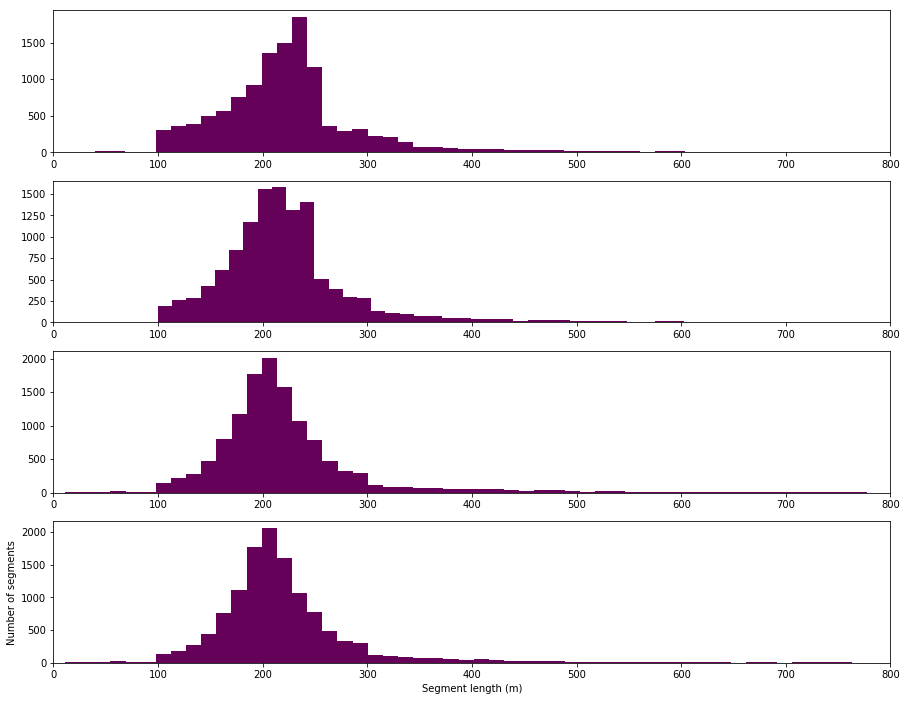

In [22]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
v1 = pd.read_sql('''select * from congestion.segments_v1''',con)
v2 = pd.read_sql('''select * from congestion.segments_v2''',con)
v3 = pd.read_sql('''select * from congestion.segments_v3''',con)
v4 = pd.read_sql('''select * from congestion.segments_v4''',con)

fig, ax = plt.subplots(4, 1, figsize=(15,12))
ax[0].set_xlim(0, 800)
ax[1].set_xlim(0, 800)
ax[2].set_xlim(0, 800)
ax[3].set_xlim(0, 800)
ax[0].hist(v1.length, bins=100, color = colour.purple)
ax[1].hist(v2.length, bins=100, color = colour.purple)
ax[2].hist(v3.length, bins=100, color = colour.purple)
ax[3].hist(v4.length, bins=100, color = colour.purple)


plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')

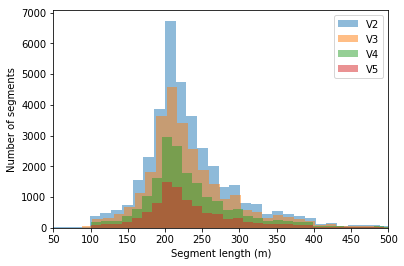

In [17]:
v2 = pd.read_sql('''select segment_id, length from congestion.partition_all_possibility_v2''',con)
v3 = pd.read_sql('''select segment_id, length from congestion.partition_all_possibility_v3''',con)
v4 = pd.read_sql('''select segment_id, length from congestion.partition_all_possibility_v4''',con)
v5 = pd.read_sql('''select segment_id, length from congestion.partition_all_possibility_v5''',con)
plt.hist(v2.length, 100, alpha=0.5, label='V2')
plt.hist(v3.length, 100, alpha=0.5, label='V3')
plt.hist(v4.length, 100, alpha=0.5, label='V4')
plt.hist(v5.length, 100, alpha=0.5, label='V5')


plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')
plt.xlim(50, 500)
plt.legend(loc='upper right')
plt.show()


## Best group partitioning

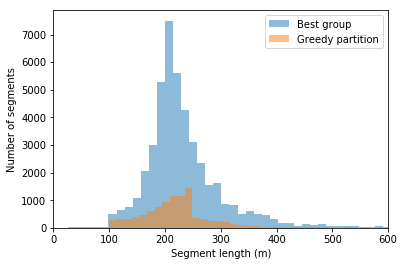

In [24]:
duration_freq1 = pd.read_sql('''select partition_result.* from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_all_possibility)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select * from congestion.partition_all_possibility''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Best group')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy partition')
plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')
plt.xlim(0, 600)
plt.legend(loc='upper right')
plt.show()


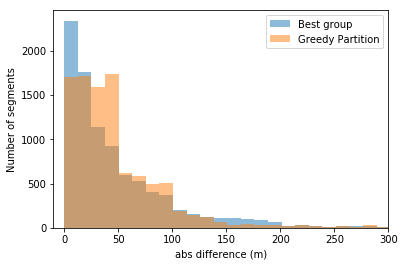

In [91]:
duration_freq1 = pd.read_sql('''select abs(200-partition_result.length) as length from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_all_possibility_v4)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select abs(200-length) as length from congestion.partition_all_possibility_v4''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Best group')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy Partition')
plt.xlabel('abs difference (m)')
plt.ylabel('Number of segments')
plt.xlim(-10, 300)
plt.legend(loc='upper right')
plt.show()

## Simulated Annealing

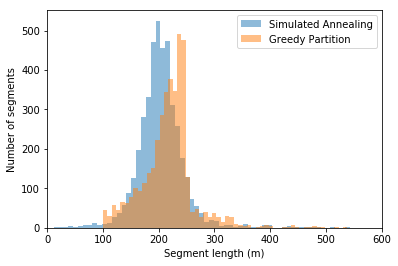

In [22]:
duration_freq1 = pd.read_sql('''select partition_result.* from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_simanneal)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select * from congestion.partition_simanneal''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Simulated Annealing')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy Partition')
plt.xlim(0, 600)
plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')
plt.legend(loc='upper right')
plt.show()

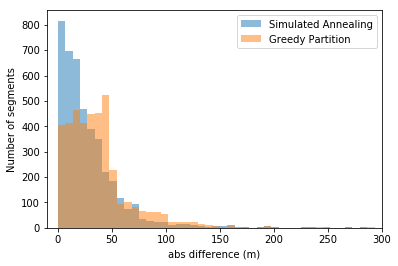

In [23]:
duration_freq1 = pd.read_sql('''select abs(200-partition_result.length) as length from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_simanneal)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select abs(200-length) as length from congestion.partition_simanneal''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Simulated Annealing')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy Partition')
plt.xlabel('abs difference (m)')
plt.ylabel('Number of segments')
plt.xlim(-10, 300)
plt.legend(loc='upper right')
plt.show()